A Trust Framework annotates data based on its provenance (e.g. encryption status, hardware installation, hardware capability, storage services).
In this work we take the California Housing dataset used to cluster based on economic status.
We then progressively "poison" this dataset with artificially modified data (an increasing proportion of the dataset is modified by a random amount on one of its fields). Entries within this poison set are given an additional Trust field with a value of 1 representing their score in the Trust Framework. Entries that aren't candidates for modification (the "Clean" set) have a Trust field set to 4
We then evaluate clustering performance using Clean data only, a mix of clean and Poisoned data, and a mix of clean and poisoned data while using the Trust value as a weighting to oversample the data based on weights.

## Load data

In [110]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import cycle, islice
from sklearn.model_selection import train_test_split
from pandas.plotting import parallel_coordinates

In [111]:
# Load data
data = pd.read_csv('../input/california-housing-prices/housing.csv')

#c,p = train_test_split(data, test_size=0.2,shuffle=True)
#data = c

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 0 to 16511
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16353 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [113]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [114]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,16512.0,-119.131148,1.922787,-124.3500,-121.240,-118.300,-117.8900,-114.3100
latitude,16512.0,35.254261,2.086646,32.5400,33.870,34.100,37.6900,41.9500
housing_median_age,16512.0,29.277313,12.789323,1.0000,19.000,30.000,38.0000,52.0000
total_rooms,16512.0,2636.520652,2249.811092,2.0000,1438.750,2105.000,3109.0000,39320.0000
total_bedrooms,16353.0,544.243625,435.900577,1.0000,297.000,436.000,648.0000,6445.0000
population,16512.0,1437.614583,1160.662101,3.0000,792.000,1168.000,1727.0000,35682.0000
households,16512.0,503.612706,392.968361,1.0000,280.000,410.000,604.0000,6082.0000
median_income,16512.0,3.800451,1.871632,0.4999,2.525,3.475,4.6389,15.0001
median_house_value,16512.0,202067.031311,113523.568387,14999.0000,118300.000,173800.000,253600.0000,500001.0000


## Scale features

In [115]:
features = ['longitude', 'latitude', 'median_income']
select_df = data[features]

select_df.columns

Index(['longitude', 'latitude', 'median_income'], dtype='object')

In [116]:
# Scale the features
X = StandardScaler().fit_transform(select_df)
X[:5]

array([[-1.61169516,  1.25839198,  2.41761472],
       [-1.60649422,  1.24880693,  2.40489816],
       [-1.6168961 ,  1.2440144 ,  1.84707938],
       [-1.62209704,  1.2440144 ,  0.98454409],
       [-1.62209704,  1.2440144 ,  0.02444394]])

## Train the model

In [117]:
kmeans = KMeans(n_clusters=8) # number of clusters must be specified
model = kmeans.fit(X)
model

KMeans(n_clusters=6)

In [118]:
centers = model.cluster_centers_
centers[:7]

array([[-0.28875635,  0.58134969, -0.67228097],
       [ 0.69555475, -0.69175683, -0.59358972],
       [ 0.49098481, -0.59582597,  2.95461629],
       [ 0.63988706, -0.68864933,  0.64010357],
       [-1.43199013,  1.26891026,  0.94422499]])

In [119]:
centers.shape


(6, 3)

In [120]:
# Function that creates a DataFrame with a column for Cluster Number
def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas data frame for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

In [121]:
# Function that creates Parallel Plots
def parallel_plot(data):
	my_colors = list(islice(cycle(['r', 'r', 'g', 'y', 'k']), None, len(data)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [122]:
P = pd_centers(features, centers)

In [123]:
# Returns the six clusters and their corresponding values for the centroids
P

,longitude,latitude,median_income,prediction
0,-0.288756,0.581350,-0.672281,0
1,0.695555,-0.691757,-0.593590,1
2,0.490985,-0.595826,2.954616,2
3,0.639887,-0.688649,0.640104,3
4,-1.431990,1.268910,0.944225,4
5,-1.447107,1.500034,-0.536157,5


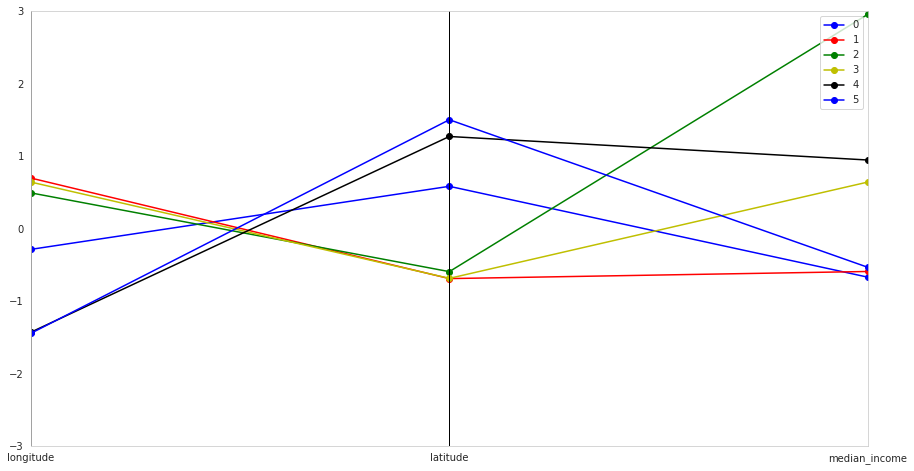

In [124]:
# Shows how different each cluster is across all features
parallel_plot(P)

In [125]:
# Create cluster label
data['econ_region'] = kmeans.fit_predict(X)
data['econ_region'] = data['econ_region'].astype("category")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,econ_region
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,1


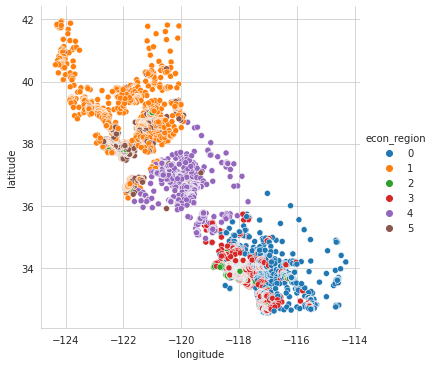

In [126]:
sns.set_style('whitegrid')
sns.relplot(x='longitude', y='latitude', hue='econ_region', data=data, kind='scatter');

In [127]:
median_attributes = ['econ_region', 'median_house_value', 'median_income', 'housing_median_age']
income_house = data[median_attributes]
income_house.groupby(['econ_region']).describe()

median_house_value                                         \
                         count           mean            std      min   
econ_region                                                             
0                       6026.0  169184.559741   80384.556365  14999.0   
1                       3235.0  156102.947759   90660.852506  14999.0   
2                        623.0  438570.179775   83446.619226  67500.0   
3                       4072.0  258144.501719  100380.411033  14999.0   
4                       1089.0   80701.285583   31881.852467  26600.0   
5                       1467.0  272497.815269  106080.228423  67500.0   

                                                    median_income            \
                  25%       50%       75%       max         count      mean   
econ_region                                                                   
0            114525.0  155500.0  198075.0  500001.0        6026.0  2.703965   
1             94300.0  131700.0  187200.0  500001.0        3235.0  2.802079   
2            378950.0  500001.0  500001.0  500001.0         623.0  9.475810   
3            183400.0  233900.0  313025.0  500001.0        4072.0  5.043045   
4             59000.0   72800.0   93100.0  450000.0        1089.0  2.544148   
5            189100.0  251600.0  342850.0  500001.0        1467.0  5.579378   

             ...                     housing_median_age                        \
             ...        75%      max              count       mean        std   
econ_region  ...                                                                
0            ...   3.303350   3.9076             6026.0  30.232327  11.549444   
1            ...   3.486650   4.3309             3235.0  32.283771  13.979018   
2            ...  10.450850  15.0001              623.0  26.329053  14.004796   
3            ...   5.616825   7.3669             4072.0  27.036100  12.379646   
4            ...   3.109400   5.0100             1089.0  26.505969  11.430827   
5            ...   6.142150  10.9590             1467.0  28.254942  14.458122   

                                          
             min   25%   50%   75%   max  
econ_region                               
0            1.0  21.0  31.0  38.0  52.0  
1            2.0  20.0  32.0  45.0  52.0  
2            2.0  16.0  25.0  36.0  52.0  
3            1.0  17.0  28.0  36.0  52.0  
4            2.0  17.0  26.0  35.0  52.0  
5            2.0  16.0  26.0  38.0  52.0  

[6 rows x 24 columns]

## Summary

* There appears to be some difference, in terms of median house value and median income, of the economic regions identified by the k-means algorithm.